In [1]:
import os, sys
import tarfile, glob
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
geo = 'GSE162534'
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_unzip = os.path.join(pth_data, 'unzip', geo)
pth_out = os.path.join(pth_data, 'processed')
pth_fig = os.path.join(pth, 'figures', 'preprocessing')

In [3]:
df_summary = pd.read_csv(os.path.join(pth_data, 'summary.csv'))
df_summary = df_summary.loc[df_summary.Source == geo]
df_summary

,Source,Name,Study,Species,Trajectory,Age,Description
1,GSE162534,Primitive Streak,"Scheibner et al., 2021",mmusculus,True,Early-Late Streak,Gastrulation dataset analyzing EMT programs du...


In [3]:
samples = sorted(os.listdir(pth_unzip))
adata_dict = {fn.replace('.tar.gz', '') : fn for fn in samples if 'velo' not in fn}
for key in adata_dict:
    with tarfile.open(os.path.join(pth_unzip, adata_dict[key]), 'r:gz') as tar:
        tar.extractall(path = os.path.join(pth_unzip, key))
    _pth_ = glob.glob(os.path.join(pth_unzip, key, '*', '*', '*', '*'))[0]
    adata_dict[key] = sc.read_10x_mtx(_pth_)
adata = ad.concat(adata_dict, label = 'sample')
adata.obs_names_make_unique(); adata

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5898240 × 27998
    obs: 'sample'

In [4]:
sc.pp.filter_cells(adata, min_genes = 1000)
adata

AnnData object with n_obs × n_vars = 11366 × 27998
    obs: 'sample', 'n_genes'

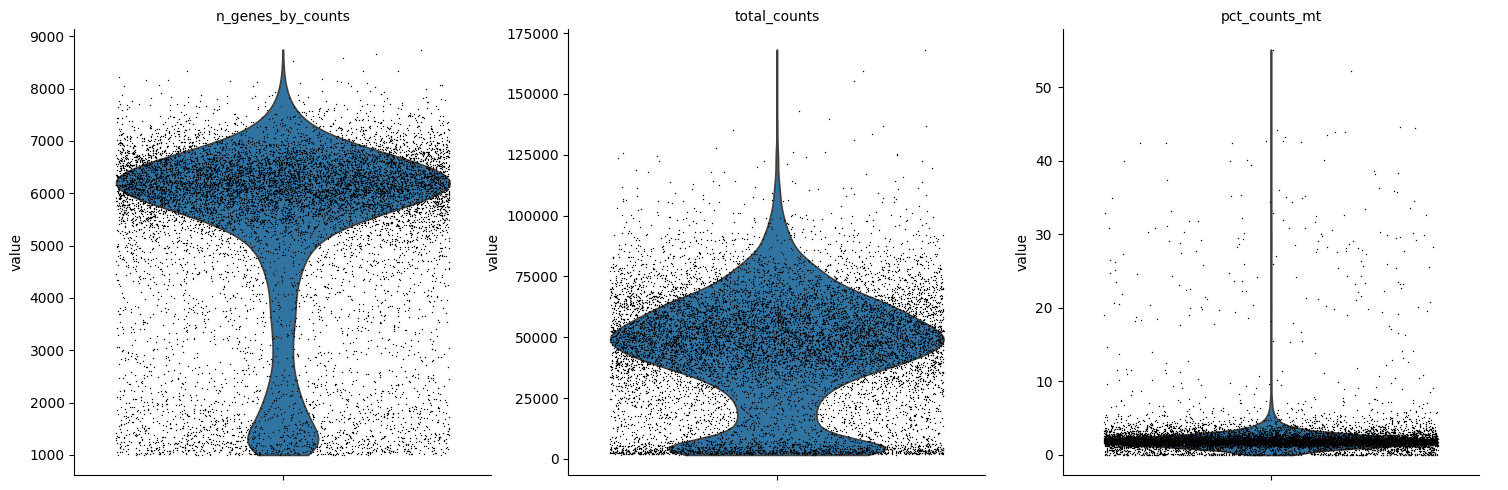

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, inplace = True, log1p = False)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = .4, multi_panel = True)

In [6]:
adata = adata[
    (adata.obs.total_counts <= 125000) &
    (adata.obs.total_counts >= 25000) &
    (adata.obs.pct_counts_mt <= 8)]
adata

View of AnnData object with n_obs × n_vars = 8897 × 27998
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3875 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



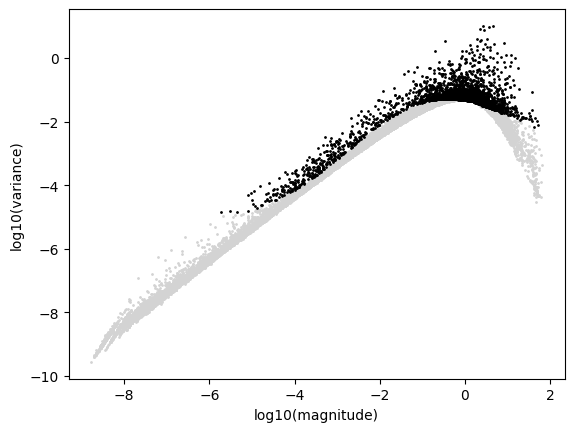

In [ ]:
sc.pp.normalize_total(adata, target_sum = 50000)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [9]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-10-13 14:57:47,258 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-13 14:57:50,069 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-13 14:57:50,111 - harmonypy - INFO - Iteration 1 of 10
2025-10-13 14:57:52,713 - harmonypy - INFO - Iteration 2 of 10
2025-10-13 14:57:54,940 - harmonypy - INFO - Iteration 3 of 10
2025-10-13 14:57:57,103 - harmonypy - INFO - Iteration 4 of 10
2025-10-13 14:57:59,169 - harmonypy - INFO - Converged after 4 iterations


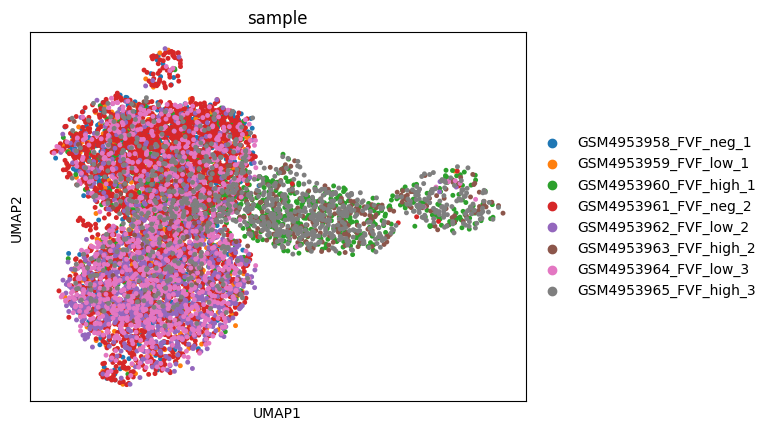

In [ ]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
sc.tl.umap(adata, spread = .2)
sc.pl.umap(adata, color = 'sample', size = 50)

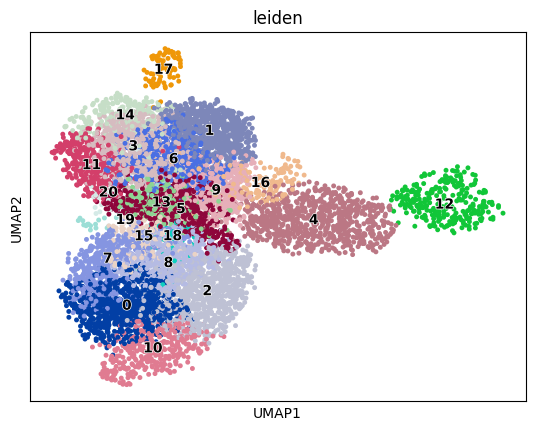

In [ ]:
sc.tl.leiden(adata, resolution = 1.2)
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)

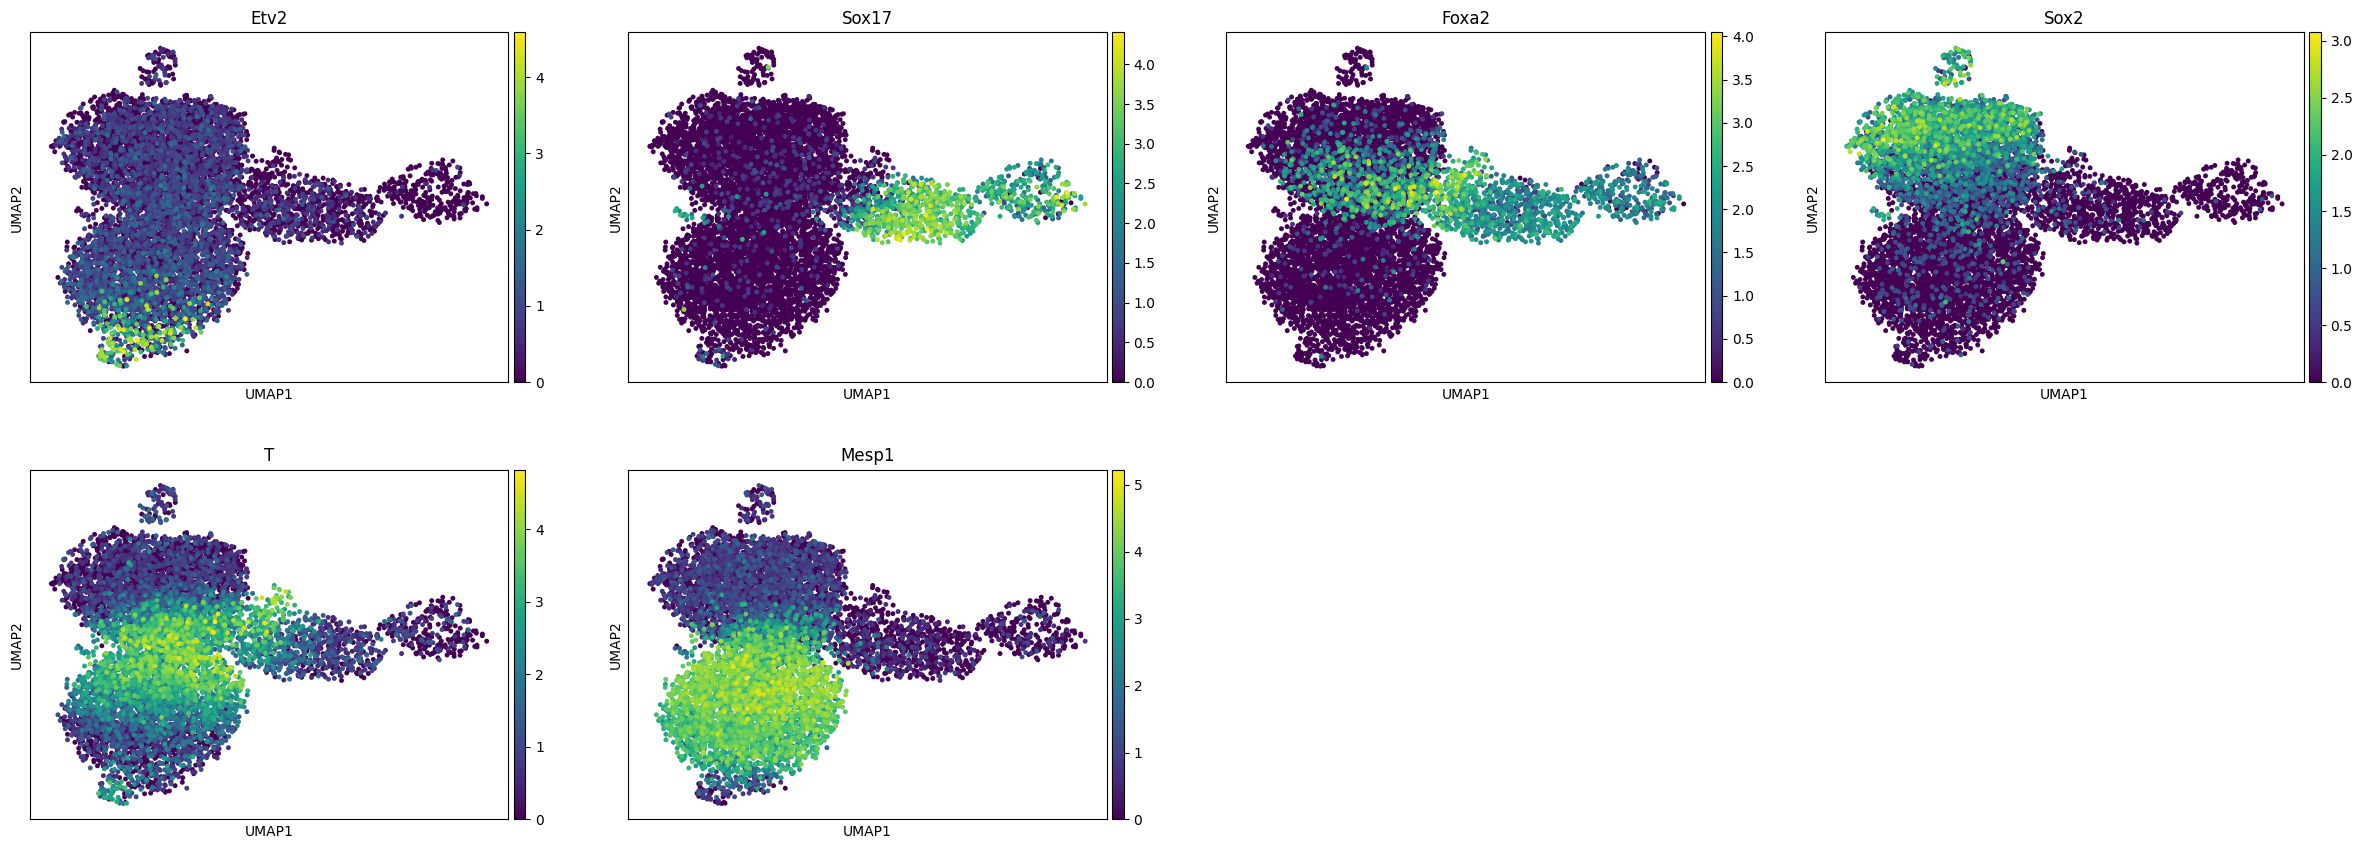

In [59]:
genes = ['Etv2', 'Sox17', 'Foxa2', 'Sox2', 'T', 'Mesp1']
sc.pl.umap(adata, color = genes, size = 50)

In [49]:
celltype_dict = {
    '0'  : 'Lateral Plate Mesoderm',
    '1'  : 'Epiblast',
    '2'  : 'Lateral Plate Mesoderm',
    '3'  : 'Epiblast',
    '4'  : 'Definitive Endoderm',
    '5'  : 'Posterior Epiblast',
    '6'  : 'Epiblast',
    '7'  : 'Lateral Plate Mesoderm',
    '8'  : 'Lateral Plate Mesoderm',
    '9'  : 'Posterior Epiblast',
    '10' : 'Nascent Endothelium',
    '11' : 'Epiblast',
    '12' : 'Definitive Endoderm',
    '13' : 'Posterior Epiblast',
    '14' : 'Epiblast',
    '15' : 'Lateral Plate Mesoderm',
    '16' : 'Axial Mesendoderm',
    '17' : 'Epiblast',
    '18' : 'Lateral Plate Mesoderm'}

adata.obs['celltype'] = adata.obs.leiden.map(celltype_dict).astype('category')

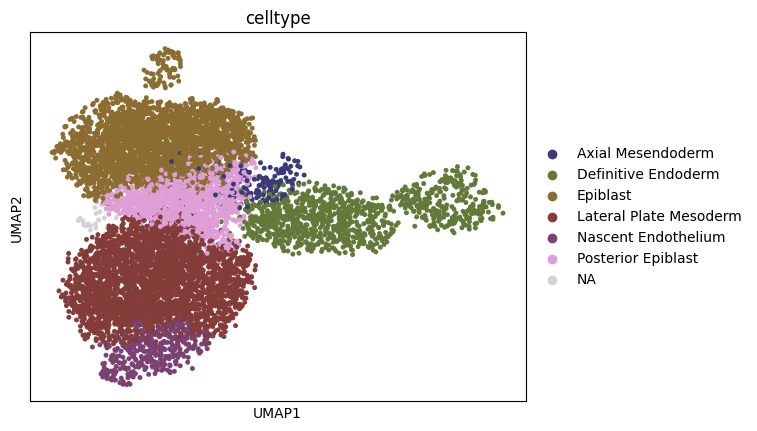

In [64]:
sc.pl.umap(adata, color = 'celltype', size = 50, palette = 'tab20b')

In [65]:
adata.write(os.path.join(pth_out, f'{geo}.h5ad'))

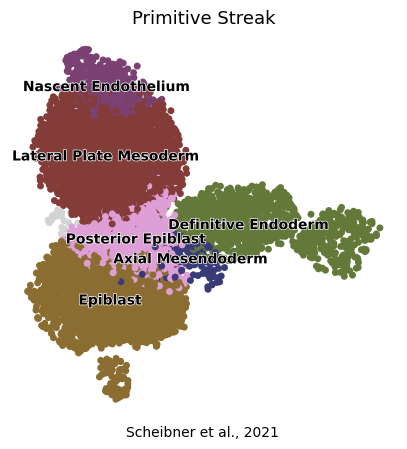

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata, color = 'celltype', size = 100,
           legend_loc = 'on data', na_in_legend = False,
           legend_fontoutline = 1, frameon = False,
           show = False, ax = ax)
ax.invert_yaxis()
ax.set_title(df_summary.Name.values[0], size = 13)
ax.text(.3, -.05, df_summary.Study.values[0], transform = ax.transAxes)
fn = os.path.join(pth_fig, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')